# OrganNet25D Demonstration

**Contents**

1. [Imports](#imports)
2. [Loading a runner](#runner)
3. [Data](#data)
4. [Model](#model)
5. [Visualise different organs](#organs)
6. [Predict](#predict)
7. [Visualise predictions](#results)

## Imports 

In [1]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [4]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "browser"

from src.utils import Logger, Timer, bcolors
from src.Runner.Runner import Runner

Logger.initialize()

 <a id=section2></a>
## Runner


In [3]:
jobs = [
    "config/demonstration.json",
]

# Create a trainer object and call him robert
worker = Runner(jobs=jobs, debug=True, wandb=False)

# Data

Get suitable samples from the data

In [5]:
dataset = worker._get_dataset(worker.job_queue[0]["training"]["dataset"])

INFO    Started loading the data set with possibly 16 samples
RUN     100.0% .................................................. importing data
LOG     Finished loading the dataset (16 samples)
LOG     Started applying the specified transformations to the samples
RUN     100.0% .................................................. transforming data
DONE    Loading of data completed




In [6]:
import pandas as pd
base_url = "https://raw.githubusercontent.com/plotly/datasets/master/ply/"
mesh_names = ["sandal", "scissors", "shark", "walkman"]
dataframes = {name: pd.read_csv(base_url + name + "-ply.csv") for name in mesh_names}


In [34]:
dataframes["sandal"]

,x,y,z,facecolor,i,j,k
0,-2.42561,-1.47236,0.132523,"rgb(31,151,139)",0,1,2
1,-2.08997,-1.88351,0.097943,"rgb(31,151,139)",2,3,0
2,-2.23897,-1.89583,0.088308,"rgb(31,150,139)",0,3,4
3,-2.44966,-1.87043,0.076921,"rgb(31,150,139)",4,5,0
4,-2.66959,-1.81592,0.066715,"rgb(31,150,139)",0,5,6
...,...,...,...,...,...,...,...
4947,NaN,NaN,NaN,"rgb(35,169,131)",2398,2626,2370
4948,NaN,NaN,NaN,"rgb(34,168,132)",2373,2622,2624
4949,NaN,NaN,NaN,"rgb(34,167,133)",2373,2624,2398
4950,NaN,NaN,NaN,"rgb(34,168,132)",2372,2622,2373


In [10]:
# Get dataloader for both training and validation
train_data, eval_data = worker._get_dataloader(
    dataset,
    split_ratio=worker.job_queue[0]["training"]["split_ratio"],
    num_workers=worker.job_queue[0]["training"]["num_workers"],
    batch_size=worker.job_queue[0]["training"]["batch_size"],
)

In [11]:
for batch, batch_input in enumerate(train_data):
    image3d, label3d = batch_input
    
    break

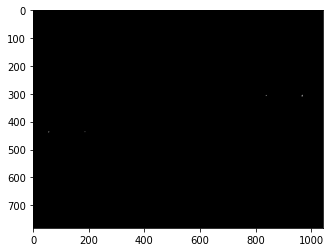

In [48]:
from torchvision.utils import make_grid

organ_idx = 5 # 9 = background

# permute to treat depth as "batch dim"
x_grid = make_grid(label3d[0, organ_idx].unsqueeze(0).permute(1, 0, 2, 3), nrow=8) 
# permute to create channels-last array (for matplotlib)
x_grid = x_grid.permute(1, 2, 0).numpy()
plt.imshow(x_grid)

(0.0, 128.0)

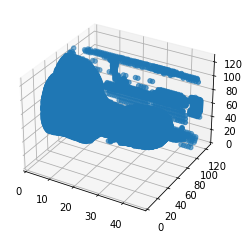

In [88]:
xyz_torch = (label3d[0, 9] > -0).nonzero(as_tuple=False)

x = xyz_torch[:,0]
y = xyz_torch[:,1]
z = xyz_torch[:,2]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
ax.set_xlim([0,48])
ax.set_ylim([0,128])
ax.set_zlim([0,128])

In [94]:
from scipy.spatial import Delaunay, ConvexHull
all_organs = []
organ_names = []
for organ_idx in range(9):
    xyz_torch = (label3d[0, organ_idx] > 0).nonzero(as_tuple=False)
    all_organs.append(xyz_torch)
    if xyz_torch.shape[0] > 0:

        plot_df = pd.DataFrame(data=xyz_torch, columns=["x", "y", "z"])
        #points2D=np.vstack([xyz_torch[:,1],xyz_torch[:,2]]).T
        #plot_df["facecolor"] = plot_df[["x", "y", "z"]].apply(lambda s: "rgb(0, {}, 0)".format(label3d[0, organ_idx][s[0], s[1], s[2]]), axis=1)
        plot_df["facecolor"] = 'rgb(35,169,131)'
        plot_df["organ_name"] = f"organ_{organ_idx}"
        organ_names.append(plot_df["organ_name"].values)
        plot_df.to_csv(f"organ_{organ_idx}.csv")
    else:
        print(f"Skipping organ {organ_idx}")

all_organs = np.concatenate(all_organs)
plot_df = pd.DataFrame(data=all_organs, columns=["x", "y", "z"])
plot_df["facecolor"] = 'rgb(35,169,131)'
plot_df["organ_names"] = np.concatenate(organ_names)
plot_df.to_csv(f"all_organs.csv")



Skipping organ 3


In [98]:
all_organs.shape

(769, 3)

In [19]:
import plotly.graph_objects as go


organ_idx = 9
separated_labels = (label3d[0, 9] > 0).nonzero(as_tuple=False)

point_coords = separated_labels


In [21]:
label3d[0,9][separated_labels].shape

In [20]:

x = point_coords[:, 0]
y = point_coords[:, 1]
z = point_coords[:, 2]
fig=go.Figure(
    go.Mesh3d(
        x=x, y=y, z=z,
        intensity=label3d[0,9]
        alphahull=0,
        opacity=0.4,
        colorscale="ice"
        )
        )
#fig.update_xaxes(range=[0, 48])
#fig.update_yaxes(range=[0, 248])
#fig.update_zaxes(range=[0, 248])
fig.show()

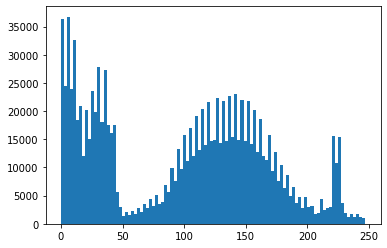

In [17]:

plt.hist(separated_labels.numpy().flatten(), bins=100)

plt.show()

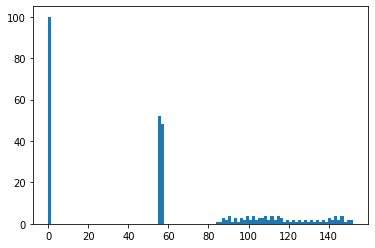

In [114]:

plt.hist(separated_labels.flatten(), bins=100)

plt.show()

In [125]:
import plotly.graph_objects as go
import numpy as np
config = dict({'scrollZoom': True})

pts = np.loadtxt(np.DataSource().open('https://raw.githubusercontent.com/plotly/datasets/master/mesh_dataset.txt'))
x, y, z = pts.T

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z,
                   alphahull=5,
                   opacity=0.4,
                   color='cyan')])
fig.show(config=config)